In [1]:
## Read satellite data
import pandas as pd
import matplotlib.pyplot as plt

def read_satellite_data(veg_type, satellite):
    # Load vegetation class table
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')

    # Filter for Forest classes
    if veg_type in (11, 12, 13, 14):
        df = df[df['veg_class'].isin([veg_type])]
    else:
        df = df[df['veg_class'].isin([11, 12, 13, 14])]

    # Separate climate/phenology columns by type
    eos_cols = [col for col in df.columns if 'eos' in col]
    t_cols = [col for col in df.columns if 'annual_t' in col]
    p_cols = [col for col in df.columns if 'annual_p' in col]
    sos_cols = [col for col in df.columns if 'sos' in col]

    # Handle satellites
    if satellite == "avhrr":
        years = [str(y) for y in range(1982, 2017)]
    elif satellite == "modis":
        years = [str(y) for y in range(2001, 2024)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)
        mask_eos = (df[eos_cols] > 365).any(axis=1)
        df = df[~(mask_sos | mask_eos)].copy()
    else:
        years = [str(y) for y in range(2013, 2023)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)
        mask_eos = (df[eos_cols] > 365).any(axis=1)
        df = df[~(mask_sos | mask_eos)].copy()

    # Keep only relevant columns
    cols = years
    df = df[[col for col in eos_cols + t_cols + p_cols + sos_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()

    # Convert temperatures from Kelvin to Celsius
    t_cols_df = [col for col in df.columns if 'annual_t' in col]
    df[t_cols_df] = df[t_cols_df] - 273.5

    # Rename columns uniformly
    df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)

    # === ADD EOS MEAN CALCULATIONS FOR AVHRR ===
    if satellite == "avhrr":
        eos_82_99_cols = [col for col in df.columns if 'eos' in col and 1982 <= int(col[-4:]) <= 1990]
        eos_00_16_cols = [col for col in df.columns if 'eos' in col and 2010 <= int(col[-4:]) <= 2016]

        df['eos_82_99'] = df[eos_82_99_cols].mean(axis=1)
        df['eos_00_16'] = df[eos_00_16_cols].mean(axis=1)

    # Compute overall means
    df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
    df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
    df['eos'] = df[[col for col in df.columns if 'eos' in col and col not in ['eos_82_99', 'eos_00_16']]].mean(axis=1)
    df['sos'] = df[[col for col in df.columns if 'sos' in col]].mean(axis=1)

    return df


In [7]:
## Plot heatmap

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter

def filter_extremes(df, x_col, y_col, z_col, name4, name5):
    x_all = df[x_col].values
    y_all = df[y_col].values*1000
    z_all = df[z_col].values
    z_all_82_99 = df[name4].values
    z_all_00_16 = df[name5].values

    x_low, x_high = np.nanpercentile(x_all, [0, 100])
    y_low, y_high = np.nanpercentile(y_all, [0, 100])
    mask = (x_all >= x_low) & (x_all <= x_high) & (y_all >= y_low) & (y_all <= y_high)
    return x_all[mask], y_all[mask], z_all[mask], z_all_82_99[mask], z_all_00_16[mask]

def classify_data(x, y, satellite):
    # temp_class = np.where(x < np.nanmean(x), 'low temp', 'High temp')
    temp_class = np.where(x < 7.25, 'low temp', 'High temp')
    if satellite == 'avhrr':
        precip_class = np.where(y < 900, 'Low prcp', 'High prcp')
    elif satellite == 'modis':
        precip_class = np.where(y < 1000, 'Low prcp', 'High prcp')
    else:
        precip_class = np.where(y < 1000, 'Low prcp', 'High prcp')
    return temp_class, precip_class


def compute_binned_means(x, y, z, min_z_count, z_82_99, z_00_16):
    bin_width_x = 0.5     # 1 degree
    bin_width_y = 100     # 100 mm

    # Compute bin edges
    x_edges = np.arange(np.floor(x.min()), np.ceil(x.max()) + bin_width_x, bin_width_x)
    y_start = np.floor(y.min() / bin_width_y) * bin_width_y
    y_end = np.ceil(y.max() / bin_width_y) * bin_width_y
    y_edges = np.arange(y_start, y_end + bin_width_y, bin_width_y)

    # === Compute 2D histogram sums and counts for z ===
    z_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z)
    z_count, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])

    # Compute mask
    valid_mask = z_count >= min_z_count

    # Compute z mean
    z_mean = np.full_like(z_sum, np.nan, dtype=np.float64)
    z_mean[valid_mask] = z_sum[valid_mask] / z_count[valid_mask]

    # === Apply same mask for z_82_99 and z_00_16 ===
    # Compute their binned means
    z82_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z_82_99)
    z00_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z_00_16)

    z_mean_82_99 = np.full_like(z82_sum, np.nan, dtype=np.float64)
    z_mean_00_16 = np.full_like(z00_sum, np.nan, dtype=np.float64)

    z_mean_82_99[valid_mask] = z82_sum[valid_mask] / z_count[valid_mask]
    z_mean_00_16[valid_mask] = z00_sum[valid_mask] / z_count[valid_mask]

    # === Calculate bin centers ===
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    # === Optional diagnostics ===
    print(f'Max count of grid: {np.nanmax(z_count)}')
    print(f'Min of z_mean: {np.nanmin(z_mean)}')

    # === Return masked means and bin centers ===
    return z_mean, z_mean_82_99, z_mean_00_16, x_centers, y_centers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize


def add_colorbar(fig, norm, z_col, vlim):
    ax_cbar = fig.add_axes([0.7, 0.55, 0.015, 0.35])
    cmap = LinearSegmentedColormap.from_list("custom_cmap",
            ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
            "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"])

    # norm = Normalize(vmin=np.nanmin(z_mean), vmax=np.nanmax(z_mean))

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cbar)
    if vlim == (250, 305):
        cbar.set_ticks([260, 280, 300])
    elif vlim == (235, 285):
        cbar.set_ticks([240, 260, 280])
    else:
        cbar.set_ticks([250, 270, 290])
        
        # ax1.set_xlabel("EOS (DOY)", fontsize=14)
        # ax2.set_ylabel("EOS (DOY)", fontsize=14)
    cbar.ax.set_ylabel("EOS (DOY)", fontsize=14)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

    cbar.ax.tick_params(labelsize=12)

    
def plot_heat_map(df, x_col, y_col, z_col, name4, name5, name1, name2, name3, title, vlim, min_z_count, satellite):
    x_display_range = (-7, 20)
    y_display_range = (300, 1750)
    x, y, z, z_82_99, z_00_16 = filter_extremes(df, x_col, y_col, z_col, name4, name5,)
    temp_class, precip_class = classify_data(x, y, satellite)
    # breakpoint_temp = find_breakpoint_pwlf(x, z, precip_class)
    # print(breakpoint_temp)
    z_mean, z_mean_82_99, z_mean_00_16, x_bins, y_bins = compute_binned_means(x, y, z, min_z_count, z_82_99, z_00_16)
    mid_x = (x_bins[:-1] + x_bins[1:]) / 2
    mid_y = (y_bins[:-1] + y_bins[1:]) / 2
    fig = plt.figure(figsize=(12, 6)) ################################################################### Figure
    plot_main_heatmap(x, y, z_mean, z_mean_82_99, z_mean_00_16, name1, name2, x_bins, y_bins, x_display_range, y_display_range, vlim, satellite)

def plot_grid(df, name1, name2, name3, name4, name5, title, vlim, min_z_count, satellite):
    plot_heat_map(df, name1, name2, name3, name4, name5, name1, name2, name3, title, vlim, min_z_count, satellite)

In [16]:
def plot_main_heatmap(x, y, z_mean, z_82_99, z_00_16,
                      name1, name2, x_bins, y_bins,
                      x_display_range, y_display_range,
                      vlim, satellite, diff_vlim=(-15, 15)):

    # === Compute bin edges ===
    x_step = x_bins[1] - x_bins[0]
    y_step = y_bins[1] - y_bins[0]
    x_edges = np.concatenate([[x_bins[0] - x_step / 2], x_bins + x_step / 2])
    y_edges = np.concatenate([[y_bins[0] - y_step / 2], y_bins + y_step / 2])

    # === Prepare datasets and titles (exclude z_mean) ===
    datasets = [z_82_99, z_00_16]
    titles = [f"1982–1999", f"2000–2016"]

    # === Base colormap ===
    cmap_main = LinearSegmentedColormap.from_list(
        "custom_cmap",
        ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da",
         "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"]
    )

    # === Normalization for main plots ===
    vmin, vmax = vlim
    if vmin is None:
        vmin = np.nanmin([np.nanmin(z) for z in datasets])
    if vmax is None:
        vmax = np.nanmax([np.nanmax(z) for z in datasets])
    norm_main = Normalize(vmin=vmin, vmax=vmax)

    # === Difference dataset ===
    diff = z_00_16 - z_82_99
    import matplotlib as mpl
    cmap_diff = mpl.colormaps["RdBu_r"]
    norm_diff = Normalize(vmin=diff_vlim[0], vmax=diff_vlim[1])

    # === Helper to plot each dataset ===
    def plot_single_heatmap(z_data, title, cmap, norm, cbar_label, fname):
        fig, ax = plt.subplots(figsize=(6, 3.5))
        im = ax.imshow(z_data.T, origin='lower',
                       extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                       cmap=cmap, norm=norm, aspect='auto')

        ax.set_xlim(*x_display_range)
        ax.set_ylim(*y_display_range)
        ax.set_yticks([400, 800, 1200, 1600])
        ax.set_ylabel("MAP (mm/year)", fontsize=12)
        # ax.set_title(title, fontsize=13)

        # === Region guide lines ===
        if satellite == 'avhrr':
            ax.axhline(y=900, color='black', linestyle='--', linewidth=1.0)
            ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=900,
                      colors='black', linestyles='--', linewidth=1.0)
        elif satellite == 'modis':
            ax.axhline(y=1000, color='black', linestyle='--', linewidth=1.0)
            ax.vlines(x=6.75, ymin=ax.get_ylim()[0], ymax=1000,
                      colors='black', linestyles='--', linewidth=1.0)
        else:
            ax.axhline(y=1000, color='black', linestyle='--', linewidth=1.0)
            ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=1000,
                      colors='black', linestyles='--', linewidth=1.0)

        # === Region labels ===
        ax.text(x_display_range[1] - 0.5, y_display_range[1] - 50,
                "Wet regions", ha='right', va='top', fontsize=10, color='black')
        ax.text(x_display_range[1] - 0.5, y_display_range[0] + 50,
                "Hot-dry regions", ha='right', va='bottom', fontsize=10, color='black')
        ax.text(x_display_range[1] - 15, y_display_range[0] + 18,
                "Cold-dry regions", ha='right', va='bottom', fontsize=10, color='black')

        # === Colorbar ===
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.03)
        cbar.set_label(cbar_label, fontsize=11)
        if cbar_label == "ΔEOS (days)":
            cbar.set_ticks([-10, -5, 0, 5, 10])
        else:
            cbar.set_ticks([260, 280, 300])

        ax.set_xlabel("MAT (°C)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.savefig(fname, dpi=800, bbox_inches='tight')
        plt.show()

    # === Plot each separately ===
    plot_single_heatmap(z_82_99, "1982–1999", cmap_main, norm_main, "EOS (DOY)",
                        f"../results/ed_figures/ed_fig4/1982_1999.png")
    plot_single_heatmap(z_00_16, "2000–2016", cmap_main, norm_main, "EOS (DOY)",
                        f"../results/ed_figures/ed_fig4/2000_2016.png")
    plot_single_heatmap(diff, "Difference (2000–2016 minus 1982–1999)",
                        cmap_diff, norm_diff, "ΔEOS (days)",
                        f"../results/ed_figures/ed_fig4/difference.png")

Max count of grid: 3127.0
Min of z_mean: 254.58994708994706


<Figure size 1200x600 with 0 Axes>

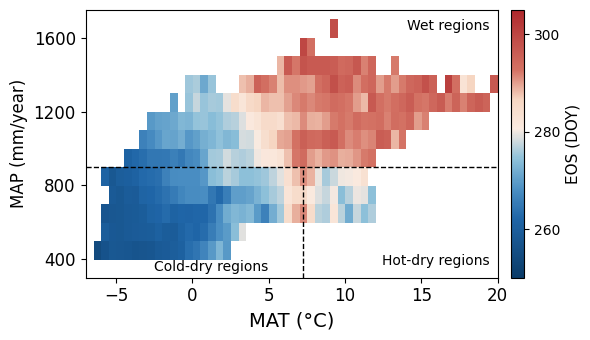

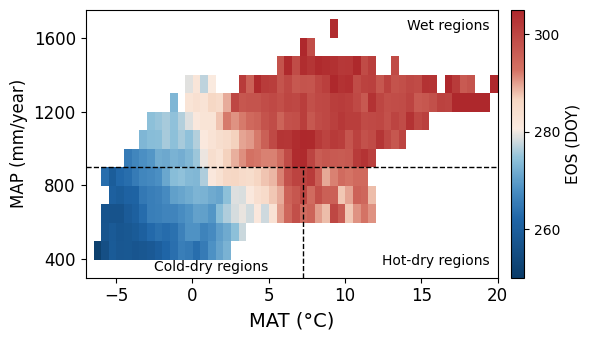

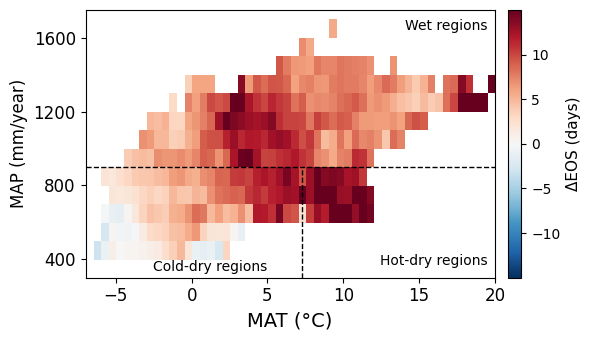

In [18]:
## Plot Extended Data Fig. 1
satellite = 'avhrr'

veg_type = 0
df = read_satellite_data(veg_type, satellite)

df = df[
    (df['annual_t'] >= -20) & (df['annual_t'] <= 20) &
    (df['annual_p'] >= 0) & (df['annual_p'] <= 4)
]

min_z_count = 50
if satellite == "avhrr":
    min_eos, max_eos = 250, 305
elif satellite == "modis":
    min_eos, max_eos = 235, 285
else:
    min_eos, max_eos =245, 295

figa = plot_grid(df, 'annual_t', 'annual_p', 'eos', 'eos_82_99', 'eos_00_16', 'AVHRR EOS', (min_eos, max_eos), min_z_count, satellite)